<a href="https://colab.research.google.com/github/LeeSeungwon89/Deep-learning_Theory/blob/main/9-2%20%EC%88%9C%ED%99%98%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9C%BC%EB%A1%9C%20IMDB%20%EB%A6%AC%EB%B7%B0%20%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **9-2 순환 신경망으로 IMDB 리뷰 분류하기**

IMDB 리뷰 데이터 세트로 간단한 순환 신경망 모델을 훈련해 보겠습니다. 이 데이터 세트를 두 가지 방법(원-핫 인코딩, 단어 임베딩)으로 변형하여 순환 신경망에 주입해 보겠습니다.

## **IMDB 리뷰 데이터셋**

IMDB 리뷰 데이터 세트는 인터넷 영화 데이터베이스인 imdb.com 사이트에서 수집한 리뷰를 긍정과 부정으로 분류한 데이터 세트입니다. 샘플 50,000개로 구성되며 훈련 데이터와 테스트 데이터는 25,000개씩 구성됩니다.

**자연어 처리(natural language processing, NLP)**는 컴퓨터를 사용하여 인간의 언어(자연어)를 처리하는 분야입니다. 대표되는 세부 분야는 음성 인식, 기계 번역, 감성 분석 등입니다. 이 챕터에서 다룰 데이터 세트로는 감성 분석을 수행합니다. 자연어 처리 분야에서는 훈련 데이터를 **말뭉치(corpus)**라고 부르기도 합니다.

기실 텍스트 자체를 신경망에 전달하는 것이 아닙니다. 컴퓨터는 숫자 데이터만 처리할 수 있습니다. 합성곱 신경망에서 이미지를 다룰 때 이미지는 이미 픽셀값(정수)으로 구성되므로 숫자로 변환하는 작업이 필요하지 않습니다. 그러나 텍스트 데이터는 단어를 정수 데이터로 변환하는 작업이 필요합니다. 아래와 같은 문장이 있다고 가정하겠습니다.

He follows the cat. He loves the cat.

이 문장의 단어인 He, follows, the, cat. 등에 고유한 정수를 부여(매핑)합니다. 같은 단어에는 같은 정수를 부여합니다. 정수 사이에는 어떠한 관계도 없이 고유할 뿐입니다. 일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제하여 공백 기준으로 분리합니다. 이렇게 분리된 단어를 **토큰(token)**이라고 부릅니다. 샘플 하나는 여러 토큰으로 구성되며, 토큰 1개는 타임스템프 하나입니다. 간단한 문제라면 영어 말뭉치에서 토큰을 단어와 같다고 볼 수 있습니다. 토큰에 할당하는 정수 중에 몇 개는 특정 용도로 예약되어 있습니다. 예컨대 0은 패딩, 1은 문장 시작, 2는 어휘 사전(훈련 데이터 세트에서 고유한 단어를 뽑아 생성한 목록)에 존재하지 않는 토큰을 의미합니다. 테스트 데이터 세트에 어휘 사전에 존재하지 않는 단어가 있다면 2로 변환하여 신경망 모델에 주입합니다. 

참고로 한국어는 영어와 전혀 다릅니다. 한국어는 조사가 발달된 언어이므로 공백으로만 나눠서는 문장 의미를 제대로 분석하기 어렵습니다. 한국어에 대한 자연어 처리는 `KoNLPy`를 사용합니다.

IMDB 리뷰 데이터 세트는 영어로 된 문장입니다. 텐서플로에 이 데이터 세트를 정수로 바꾼 데이터가 포함되어 있으므로 굳이 정수로 바꾸는 작업은 필요하지 않습니다. 데이터를 준비하겠습니다.

In [1]:
from tensorflow.keras.datasets import imdb

# 가장 자주 등장하는 단어 500개만 사용하기 위해 `num_words=500`으로 지정합니다.
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
print(train_input.shape, test_input.shape)

17473536/17464789 [==============================] - 0s 0us/step
(25000,) (25000,)


처음 데이터만 확인해 보겠습니다.

In [2]:
print(train_input)

[list([1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32])
 list([1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 2, 8, 118, 2, 14, 394, 20, 13, 119, 2, 189, 102, 5, 207, 110, 2, 21, 14, 69, 188, 

리뷰 텍스트는 길이가 모두 다르므로 2차원 배열에 담지 않고 리뷰마다 별도로 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있습니다. 따라서 리스트 안에 리스트(리뷰 하나) 객체가 여러 개 나열된 형태이며 1차원 넘파이 배열입니다.

리뷰 몇 개만 길이를 확인해 보겠습니다.

In [3]:
print(len(train_input[0]))
print(len(train_input[1]))
print(len(train_input[2]))

218
189
141


각각 토큰 218개, 189개, 141개로 구성된 리뷰입니다. 리뷰 하나는 샘플 하나입니다.

첫 번째 리뷰 내용만 확인해 보겠습니다.

In [4]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


정수로 변환된 리뷰입니다. 위에서 `num_words=500`으로 지정했으므로 어휘 사전에는 단어가 500개만 구성된 상태이며, 어휘 사전에 없는 단어는 2로 대체됐습니다.

타깃 데이터를 확인해 보겠습니다.

In [5]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


부정은 0, 긍정은 1이며 이진 분류 문제입니다.

훈련 데이터 세트에서 검증 데이터 세트를 만들겠습니다.

In [6]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

리뷰의 평균 길이와 중간 길이, 최소 및 최대 길이를 확인해 보겠습니다.

In [7]:
import numpy as np

lengths = np.array([len(x) for x in train_input])
# 평균 및 중간값을 구합니다.
print(np.mean(lengths), np.median(lengths))
# 최솟값 및 최댓값을 구합니다.
print(min(lengths), max(lengths))

239.00925 178.0
11 1854


리뷰 길이 개수를 히스토그램으로 시각화해 보겠습니다.

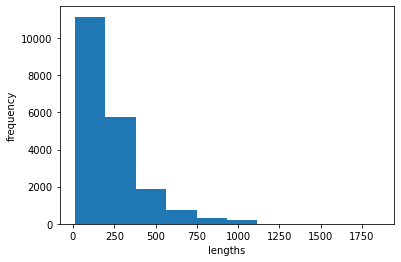

In [8]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('lengths')
plt.ylabel('frequency')
plt.show()

리뷰 대부분은 300미만의 길이를 가집니다. 평균이 중간값보다 높은 이유는 최댓값이 매우 크기 때문입니다.

리뷰 대부분 길이가 짧으므로 단어를 100개만 사용하겠습니다. 그러나 단어가 100개 미만으로 구성된 리뷰도 있으므로 리뷰 길이를 100에 맞추기 위해 패딩을 수행해야 합니다. 위에서 서술했듯이 패딩을 나타내는 토큰은 0을 사용합니다.

물론 수동으로 훈련 데이터 세트에 있는 리뷰 20,000개를 순회하면서 길이가 100이 되도록 자르거나 0으로 패딩 할 수 있지만 `pad_sequences()` 메서드를 사용하면 시퀀스 데이터 길이를 맞출 수 있습니다. `train_input`의 길이를 100으로 맞춰 보겠습니다.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# `maxlen` 매개변수에 100으로 지정하면 긴 경우는 잘라내고 짧은 경우는 0으로 패딩합니다.
train_seq = pad_sequences(train_input, maxlen=100)
print(train_seq)
print(train_seq.shape)

[[ 10   4  20 ...  10 470 158]
 [206   2  26 ...   6   2   2]
 [  2   7   2 ...   2   2  12]
 ...
 [  2  37 299 ...   7  14   2]
 [  0   0   0 ...  25 170   2]
 [  0   0   0 ...  25 194   2]]
(20000, 100)


`train_input`은 리스트 내에 리스트 객체가 구성된 1차원 배열 (20000,)이지만, `train_seq`는 리스트 내에 리스트가 구성된 2차원 배열 (20000, 100)입니다. 샘플 20,000개, 토큰(타임스텝) 개수 100개입니다.

첫 번째 샘플만 확인해 보겠습니다.

In [10]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


이 샘플 길이는 100보다 길었기 때문에 샘플 원소로 0이 없습니다. 

원본과 비교하여 앞과 뒤 중에 어떤 부분이 잘렸는지 확인해 보겠습니다.

In [11]:
# 맨 앞 원소를 10개만 확인합니다.
print(train_input[0][:10])

[1, 73, 89, 81, 25, 60, 2, 6, 20, 141]


In [12]:
# 맨 뒤 원소를 10개만 확인합니다.
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


`train_input[0]`과 `train_seq[0]`의 앞부분 원소는 불일치하지만 뒷부분 원소는 일치합니다. 앞부분이 잘렸다고 판단할 수 있습니다. 즉 `pad_sequences()` 메서드는 매개변수 `maxlen`에 지정한 값보다 긴 시퀀스의 앞부분을 자릅니다. 앞부분을 자르는 이유는 시퀀스의 뒷부분이 가진 정보가 더 유용할 것이라고 예상하기 때문입니다. 특히 이 리뷰 데이터 세트의 경우 리뷰의 앞부분보다는 뒷부분에 더 결정적이고 중요한 소감을 말할 가능성이 높습니다. 만약 뒷부분을 자르려면 매개변수 `truncating`의 디폴트인 `pre`가 아닌 `post`를 지정합니다.

이번에는 `train_seq`의 여섯 번째 샘플을 확인해 보겠습니다.

In [13]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


앞부분 원소 4개가 0입니다. 여섯 번째 샘플 길이는 96입니다. 시퀀스의 앞부분을 자르는 것과 같은 이치로써 패딩 토큰 또한 시퀀스의 뒷부분이 아닌 앞부분에 추가됩니다. 시퀀스의 마지막에 구성된 단어가 셀의 은닉 상태에 가장 큰 영향을 미칠 가능성이 높으므로 뒷부분에 패딩을 추가하는 것은 선호되는 방법이 아닙니다. 만약 패딩을 뒷부분에 추가하려면 매개변수 `padding`의 디폴트인 `pre`를 `post`로 지정합니다.

검증 데이터 세트의 길이도 100으로 지정하겠습니다.

In [14]:
val_seq = pad_sequences(val_input, maxlen=100)
print(val_seq)
print(val_seq.shape)

[[ 32   2 225 ...  14  58   2]
 [ 53   2   8 ...   7  32   2]
 [  0   0   0 ...   2  33  32]
 ...
 [383   2 120 ...  16  99  76]
 [106 345  12 ... 120   2 156]
 [  4 114  21 ...   4   2   2]]
(5000, 100)


## **순환 신경망 만들기**

케라스가 제공하는 여러 순환층 클래스 중 가장 간단한 클래스는 `SimpleRNN`입니다. 이 클래스는 챕터 7의 파트 1에서 설명한 것과 유사한 기능을 가집니다. IMDB 리뷰 분류 문제는 이진 분류 문제입니다. 따라서 마지막 출력층은 유닛 1개를 가지고 시그모이드 활성화 함수를 사용해야 합니다. 먼저 `Sequential` 클래스로 생성한 코드를 확인해 보겠습니다.

In [15]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

지금까지 살펴왔던 코드와 비슷한 형태입니다. 차이점이라면 `Dense` 클래스나 `Conv2D` 클래스 대신 `SimpleRNN` 클래스를 사용한 것입니다. `SimpleRNN` 클래스의 디폴트 활성화 함수는 하이퍼볼릭 탄젠트 함수인 `tanh`이며 다른 함수를 따로 지정하지 않았으므로 디폴트를 그대로 사용합니다.

입력 차원은 (100, 500)입니다. 첫 번째 차원은 샘플 길이가 100이므로 100입니다. 두 번째 차원이 500인 이유는 자세하게 설명할 필요가 있습니다. `train_seq`와 `val_seq`는 문제가 하나 있습니다. 토큰을 정수로 변환한 이 데이터를 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만듭니다. 큰 정수일수록 영향력이 큰 것입니다. 그러나 이 정수 간에는 어떠한 관련성도 없습니다. 예컨대 더 큰 정수인 토큰 20을 더 작은 정수인 토큰 10보다 중요시할 이유가 없습니다. 단순한 정숫값을 신경망에 입력하려면 정숫값의 크기 속성을 없애고 각 정수를 고유하게 표현해야 합니다. 이를 구현할 방법은 원-핫 인코딩입니다. 토큰 10을 원-핫 인코딩으로 바꾸면 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..., 0이 됩니다. 열한 번째 원소만 1이고 나머지는 0입니다. 이 배열의 길이가 중요합니다. 처음 `imdb.load_data()` 메서드로 데이터를 생성할 때 단어를 500개만 사용하도록 지정했으므로 고유 단어는 500개입니다. 훈련 데이터 세트에 포함될 수 있는 정숫값 범위는 패딩 토큰인 0부터 499까지입니다. 이 범위를 원-핫 인코딩으로 표현하면 배열 길이는 500이 됩니다. 원-핫 인코딩을 수행하는 케라스의 유틸리티는 `keras.utils` 패키지의 `to_categorical()` 메서드입니다. 아래처럼 메서드에 정수 배열을 입력하면 원-핫 인코딩된 배열을 생성합니다.

In [16]:
train_oh = keras.utils.to_categorical(train_seq)
print(train_oh)
print(train_oh.shape)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]]
(20000, 10

정수마다 500차원 배열로 바뀌었으므로 (20000, 100, 500) 크기가 됐습니다. 이처럼 샘플 데이터 크기가 1차원 정수 배열 (100, )에서 2차원 배열(100, 500)으로 바뀌면서 입력값인 `input_shape`를 (100, 500)으로 지정했습니다.

`train_oh`의 첫 번째 샘플의 첫 번째 토큰 10이 어떻게 인코딩됐는지 확인해 보겠습니다.

In [17]:
# 첫 번째 샘플의 첫 번째 토큰 10을 확인합니다.
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [18]:
# 첫 번째 샘플의 첫 번째 토큰10이 원-핫 인코딩된 결과를 확인합니다.
print(train_oh[0][0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

열한 번째만 1이고 나머지는 0입니다. 본서에서는 `print(train_oh[0][0][:12])`로 앞부분 원소만 출력했으나 여기서는 전체를 출력해 봤습니다.

아래처럼 모든 원소를 더하면 당연히 1이 됩니다. 원소 하나만 1이기 때문입니다.

In [19]:
print(np.sum(train_oh[0][0]))

1.0


`val_seq`도 원-핫 인코딩을 수행하겠습니다.

In [20]:
val_oh = keras.utils.to_categorical(val_seq)
print(val_oh[0])
print(val_oh.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(5000, 100, 500)


모든 데이터 세트를 준비했습니다.

모델 구조를 확인해 보겠습니다.

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


`SimpleRNN`에 전달할 샘플 크기는 (100, 500)이지만 이 순환층은 마지막 타임스텝의 은닉 상태만 출력합니다. 따라서 출력 크기가 순환층의 유닛 개수와 동일한 8입니다(위에서 8로 지정했습니다).

순환층에 사용된 모델 파라미터 개수를 산출해 보겠습니다. 입력 토큰은 500차원의 원-핫 인코딩 배열이며, 이 배열이 순환층의 유닛 8개와 완전히 연결되므로 가중치 개수는 500 x 8 = 4,000개입니다. 순환층의 은닉 상태는 다시 다음 타임스텝에 사용되기 위해 또 다른 가중치와 곱해집니다. 이 은닉 상태도 순환층의 유닛과 완전히 연결되므로 가중치는 8(은닉 상태 크기) x 8(유닛 개수) = 64개가 됩니다. 유닛마다 절편 하나가 존재하므로 총 파라미터 개수는 4,000 + 64 + 8 = 4,072개입니다.

## **순환 신경망 훈련하기**

순환 신경망은 완전 연결 신경망 및 합성곱 신경망과 모델을 생성하는 방법은 다르지만 훈련하는 방법은 같습니다. 아래 코드로 구현하고 설명을 이어가겠습니다.

In [22]:
# 기본 RMSprop의 학습률 0.001을 사용하지 않기 위해 
# 별도로 RMSprop 객체를 생성하여 학습률을 0.0001로 지정합니다.
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, 
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 14s 41ms/step - loss: 0.6970 - accuracy: 0.5132 - val_loss: 0.6916 - val_accuracy: 0.5322
Epoch 2/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6794 - accuracy: 0.5745 - val_loss: 0.6731 - val_accuracy: 0.5940
Epoch 3/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6631 - accuracy: 0.6206 - val_loss: 0.6576 - val_accuracy: 0.6268
Epoch 4/100
313/313 [==============================] - 12s 40ms/step - loss: 0.6427 - accuracy: 0.6552 - val_loss: 0.6363 - val_accuracy: 0.6632
Epoch 5/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6209 - accuracy: 0.6873 - val_loss: 0.6182 - val_accuracy: 0.6896
Epoch 6/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5993 - accuracy: 0.7127 - val_loss: 0.6001 - val_accuracy: 0.7016
Epoch 7/100
313/313 [==============================] - 13s 40ms/step - loss: 0.5797 - accuracy: 0.7311 - val_loss: 0.5815 - val_ac

32번째 에포크에서 조기 종료 됐습니다. 검증 데이터 세트에 대한 정확도는 약 78.5%입니다.

훈련 손실과 검증 손실을 그래프로 그려 보겠습니다.

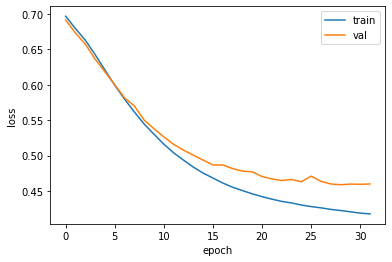

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 손실은 지속적으로 감소하지만 검증 손실은 대략 20번째 에포크에서 감소 정도가 덜합니다. 적절한 에포크에서 훈련을 멈췄습니다. 

한 가지 고려할 점이라면 원-핫 인코딩을 수행한 데이터는 입력 데이터가 커져서 메모리 소모가 많습니다. 데이터 크기를 확인해 보겠습니다.

In [24]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


토큰 1개를 500차원으로 늘렸으므로 500배 정도 커진 셈입니다. 훈련 데이터가 커질수록 압도적인 크기로 커지기 때문에 결코 적절한 방법은 아닙니다. 아래 파트에서 더 나은 단어 표현 방법을 살펴 보겠습니다.

## **단어 임베딩을 사용하기**



---

작업 중

---

